# Improving RNN Performance and Generalizability

In this notebook, we will review three advanced techniques for improving the performance and generalization power of recurrent neural networks. We will demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries.

We will cover the following techniques:

* *__Recurrent dropout__*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *__Stacking recurrent layers__*, to increase the representational power of the network (at the cost of higher computational loads).
* *__Bidirectional recurrent layers__*, which presents the same information to a recurrent network in different ways, increasing accuracy and 
mitigating forgetting issues.

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDb dataset. But sequence 
data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded every 10 minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.

Let's take a look at the data:

In [0]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os

# Import the TF V2 through this magic command
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)
import keras
from keras.datasets import imdb
from keras import preprocessing

2.2.0-rc3


In [0]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
fname = 'drive/My Drive/Teaching/BST 261/2020/In progress notebooks/jena_climate_2009_2016.csv'

In [0]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')     # Each line is 1 recording
header = lines[0].split(',') # Variable names are separated by commas
lines = lines[1:]            # Drop first line (it's a header)

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Let's convert all of these 420,551 lines of data into a Numpy array:

In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420551, 14)


For instance, here is the plot of temperature (in degrees Celsius) over time:

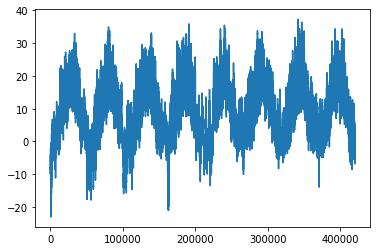

In [0]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
#plt.show()


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

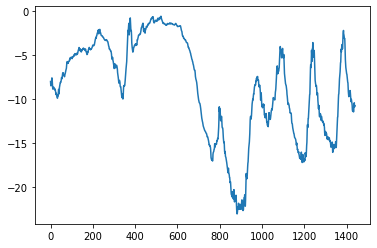

In [0]:
plt.plot(range(1440), temp[:1440])
plt.show()


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be 
coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is 
this timeseries predictable at a daily scale? Let's find out.

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 1440`, i.e. our observations will go back 10 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

print(val_steps)
print(test_steps)

769
930


## A common sense, non-machine learning baseline


Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for 
which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more 
common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the 
temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 
24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 
Mean Absolute Error is simply equal to `mean(abs(predictions - targets))`.

Here's our evaluation loop:

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])),

  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 14s 28ms/step - loss: 1.2441 - val_loss: 0.6557
Epoch 2/20
500/500 [==============================] - 13s 27ms/step - loss: 0.4048 - val_loss: 0.3310
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2927 - val_loss: 0.3093
Epoch 4/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2671 - val_loss: 0.3060
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2537 - val_loss: 0.3083
Epoch 6/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2436 - val_loss: 0.3319
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2373 - val_loss: 0.3254
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2324 - val_loss: 0.3162
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2268 - val_loss: 0.3168
Epoch 10/20
500/500 [==============================] - 14s 27ms/step - loss: 0.222

Let's display the loss curves for validation and training:

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


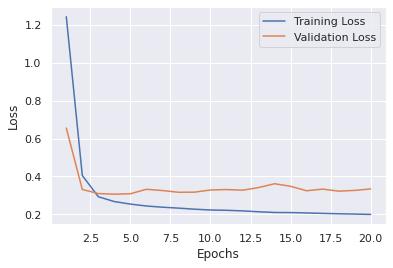

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(32, input_shape=(None, float_data.shape[-1])),

  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 86s 172ms/step - loss: 0.3163 - val_loss: 0.2723
Epoch 2/20
500/500 [==============================] - 85s 169ms/step - loss: 0.2826 - val_loss: 0.2780
Epoch 3/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2768 - val_loss: 0.2654
Epoch 4/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2736 - val_loss: 0.2647
Epoch 5/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2690 - val_loss: 0.2632
Epoch 6/20
500/500 [==============================] - 86s 172ms/step - loss: 0.2660 - val_loss: 0.2614
Epoch 7/20
500/500 [==============================] - 86s 171ms/step - loss: 0.2627 - val_loss: 0.2633
Epoch 8/20
500/500 [==============================] - 86s 172ms/step - loss: 0.2570 - val_loss: 0.2672
Epoch 9/20
500/500 [==============================] - 86s 173ms/step - loss: 0.2535 - val_loss: 0.2632
Epoch 10/20
500/500 [==============================] - 85s 171ms/step - l

Let look at our results:

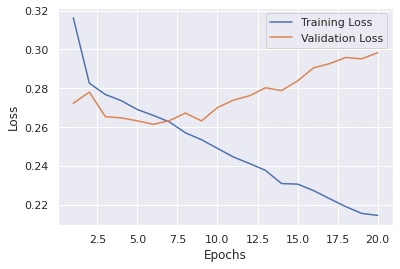

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after 
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(32, 
                      dropout = 0.2,
                      recurrent_dropout=0.2,
                      input_shape=(None, float_data.shape[-1])),

  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 151s 302ms/step - loss: 0.3291 - val_loss: 0.2800
Epoch 2/40
500/500 [==============================] - 150s 300ms/step - loss: 0.3038 - val_loss: 0.2753
Epoch 3/40
500/500 [==============================] - 150s 300ms/step - loss: 0.3002 - val_loss: 0.2809
Epoch 4/40
500/500 [==============================] - 151s 302ms/step - loss: 0.2954 - val_loss: 0.2732
Epoch 5/40
500/500 [==============================] - 151s 301ms/step - loss: 0.2900 - val_loss: 0.2712
Epoch 6/40
500/500 [==============================] - 151s 301ms/step - loss: 0.2872 - val_loss: 0.2696
Epoch 7/40
500/500 [==============================] - 151s 302ms/step - loss: 0.2830 - val_loss: 0.2721
Epoch 8/40
500/500 [==============================] - 151s 302ms/step - loss: 0.2805 - val_loss: 0.2703
Epoch 9/40
500/500 [==============================] - 151s 301ms/step - loss: 0.2759 - val_loss: 0.2714
Epoch 10/40
500/500 [==============================] - 151s 302m

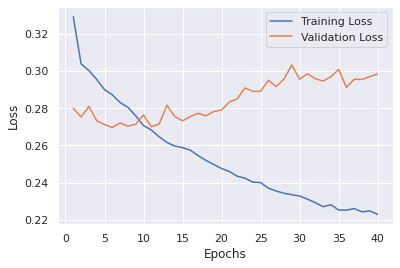

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(32, 
                      dropout = 0.1,
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, float_data.shape[-1])),
  tf.keras.layers.GRU(64, activation='relu',
                      dropout = 0.1,
                      recurrent_dropout=0.5),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 404s 808ms/step - loss: 0.3207 - val_loss: 0.2847
Epoch 2/40
500/500 [==============================] - 413s 827ms/step - loss: 0.3048 - val_loss: 0.2773
Epoch 3/40
500/500 [==============================] - 410s 820ms/step - loss: 0.2957 - val_loss: 0.2687
Epoch 4/40
500/500 [==============================] - 407s 814ms/step - loss: 0.2889 - val_loss: 0.2663
Epoch 5/40
500/500 [==============================] - 410s 820ms/step - loss: 0.2822 - val_loss: 0.2749
Epoch 6/40
500/500 [==============================] - 408s 815ms/step - loss: 0.2753 - val_loss: 0.2773
Epoch 7/40
500/500 [==============================] - 408s 816ms/step - loss: 0.2718 - val_loss: 0.2703
Epoch 8/40
500/500 [==============================] - 413s 826ms/step - loss: 0.2669 - val_loss: 0.2810
Epoch 9/40
500/500 [==============================] - 416s 832ms/step - loss: 0.2627 - val_loss: 0.2799
Epoch 10/40
500/500 [==============================] - 419s 839m

Let's take a look at our results:

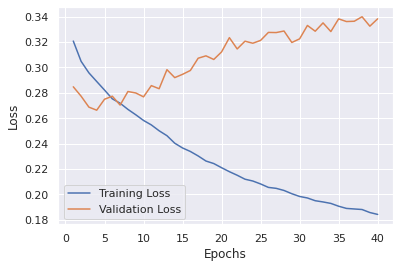

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The overfitting becomes worse, signaling the network capacity is too high, i.e. the model is too complex and has too many parameters. We shouldn't add layers in this case.

## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which 
can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it 
the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(32, input_shape=(None, float_data.shape[-1])),

  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='mae')

history = model.fit(train_gen_reverse,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen_reverse,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 79s 158ms/step - loss: 0.4772 - val_loss: 0.4842
Epoch 2/20
500/500 [==============================] - 78s 156ms/step - loss: 0.4360 - val_loss: 0.4664
Epoch 3/20
500/500 [==============================] - 78s 157ms/step - loss: 0.3868 - val_loss: 0.4598
Epoch 4/20
500/500 [==============================] - 78s 157ms/step - loss: 0.3542 - val_loss: 0.4327
Epoch 5/20
500/500 [==============================] - 78s 157ms/step - loss: 0.3323 - val_loss: 0.4135
Epoch 6/20
500/500 [==============================] - 80s 159ms/step - loss: 0.3158 - val_loss: 0.4202
Epoch 7/20
500/500 [==============================] - 82s 164ms/step - loss: 0.3020 - val_loss: 0.4010
Epoch 8/20
500/500 [==============================] - 80s 161ms/step - loss: 0.2930 - val_loss: 0.4045
Epoch 9/20
500/500 [==============================] - 79s 159ms/step - loss: 0.2812 - val_loss: 0.4065
Epoch 10/20
500/500 [==============================] - 79s 159ms/step - l

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


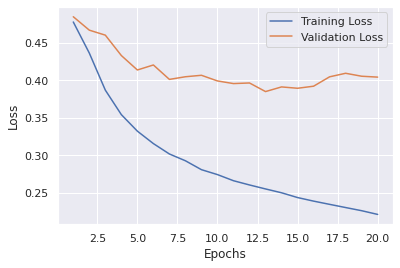

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very 
important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the 
recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our 
problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is 
bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural 
language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's 
try the same trick on the LSTM IMDB example from the previous section:

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_features, 128),
  tf.keras.layers.LSTM(32),

  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='binary_crossentropy',
              metrics = 'accuracy')

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 2s 0us/step
Epoch 1/10
157/157 [==============================] - 68s 436ms/step - loss: 0.4836 - accuracy: 0.7722 - val_loss: 0.3705 - val_accuracy: 0.8510
Epoch 2/10
157/157 [==============================] - 70s 448ms/step - loss: 0.3090 - accuracy: 0.8845 - val_loss: 0.3042 - val_accuracy: 0.8838
Epoch 3/10
157/157 [==============================] - 71s 450ms/step - loss: 0.2515 - accuracy: 0.9047 - val_loss: 0.3087 - val_accuracy: 0.8732
Epoch 4/10
157/157 [==============================] - 70s 447ms/step - loss: 0.2093 - accuracy: 0.9266 - val_loss: 0.4059 - val_accuracy: 0.8226
Epoch 5/10
157/157 [==============================] - 71s 451ms/step - loss: 0.1929 - accuracy: 0.9313 - val_loss: 0.3465 - val_accuracy: 0.8538
Epoch 6/10
157/157 [==============================] - 71s 450ms/step - loss: 0.1691 - accuracy: 0.9410 - val_loss: 0.3443 - val_accuracy: 0.8754
Epoch 7/10
157/157 [==============================] - 71s 450ms/s


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our 
hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained 
on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would 
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and 
you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the 
more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other 
approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will 
introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both 
ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_features, 32),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

history = model.fit(x_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 91s 581ms/step - loss: 0.5761 - accuracy: 0.7066 - val_loss: 0.4418 - val_accuracy: 0.8224
Epoch 2/10
157/157 [==============================] - 91s 578ms/step - loss: 0.3811 - accuracy: 0.8461 - val_loss: 0.3679 - val_accuracy: 0.8456
Epoch 3/10
157/157 [==============================] - 94s 598ms/step - loss: 0.2875 - accuracy: 0.8906 - val_loss: 0.3669 - val_accuracy: 0.8584
Epoch 4/10
157/157 [==============================] - 89s 569ms/step - loss: 0.2405 - accuracy: 0.9136 - val_loss: 0.3651 - val_accuracy: 0.8688
Epoch 5/10
157/157 [==============================] - 89s 569ms/step - loss: 0.2105 - accuracy: 0.9251 - val_loss: 0.5800 - val_accuracy: 0.7850
Epoch 6/10
157/157 [==============================] - 89s 569ms/step - loss: 0.1914 - accuracy: 0.9323 - val_loss: 0.3342 - val_accuracy: 0.8858
Epoch 7/10
157/157 [==============================] - 89s 569ms/step - loss: 0.1711 - accuracy: 0.9420 - val_loss: 0.4049 - val_ac

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to 
overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some 
regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32),
                                input_shape=(None, float_data.shape[-1])),

  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(), 
              loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2939 - val_loss: 0.2699
Epoch 2/40
500/500 [==============================] - 139s 277ms/step - loss: 0.2764 - val_loss: 0.2665
Epoch 3/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2691 - val_loss: 0.2640
Epoch 4/40
500/500 [==============================] - 140s 279ms/step - loss: 0.2631 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 140s 279ms/step - loss: 0.2582 - val_loss: 0.2647
Epoch 6/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2519 - val_loss: 0.2697
Epoch 7/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2452 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2398 - val_loss: 0.2753
Epoch 9/40
500/500 [==============================] - 141s 281ms/step - loss: 0.2354 - val_loss: 0.2789
Epoch 10/40
500/500 [==============================] - 139s 278m


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the 
chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because 
the recent past matters much more than the distant past in this case).


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


# Sequence processing with convnets
## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5: they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, 
allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution 
layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would 
only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_features, 128, input_length=max_len),
  tf.keras.layers.Conv1D(32, 7, activation='relu'),
  tf.keras.layers.MaxPooling1D(5),
  tf.keras.layers.Conv1D(32, 7, activation='relu'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=1e-4),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but 
runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, 
we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D 
convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

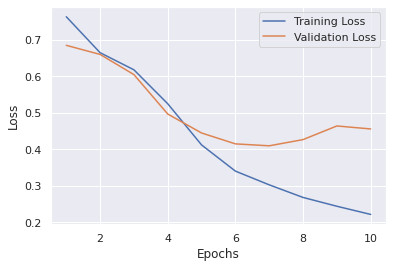

In [0]:
import seaborn as sns
sns.set()

train_acc  = history.history['accuracy']
train_loss = history.history['loss']
val_acc  = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

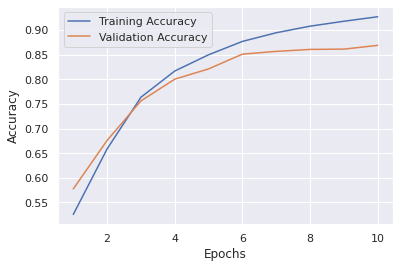

In [0]:
plt.plot(epochs, train_acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Combining CNNs and RNNs to process long sequences


Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the 
size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many 
convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a 
fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem 
from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

In [0]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Mounted at /content/drive


In [0]:
# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

# Change to your directory
data_dir = 'drive/My Drive/Teaching/BST 261/2020/In progress notebooks'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])),
  tf.keras.layers.MaxPooling1D(3),
  tf.keras.layers.Conv1D(32, 5, activation='relu'),
  tf.keras.layers.MaxPooling1D(3),
  tf.keras.layers.Conv1D(32, 5, activation='relu'),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 38s 77ms/step - loss: 0.4149 - val_loss: 0.4784
Epoch 2/20
500/500 [==============================] - 38s 77ms/step - loss: 0.3577 - val_loss: 0.4238
Epoch 3/20
500/500 [==============================] - 42s 84ms/step - loss: 0.3353 - val_loss: 0.4178
Epoch 4/20
500/500 [==============================] - 38s 76ms/step - loss: 0.3156 - val_loss: 0.4405
Epoch 5/20
500/500 [==============================] - 39s 77ms/step - loss: 0.3027 - val_loss: 0.4272
Epoch 6/20
500/500 [==============================] - 38s 77ms/step - loss: 0.2932 - val_loss: 0.4394
Epoch 7/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2854 - val_loss: 0.4516
Epoch 8/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2799 - val_loss: 0.4291
Epoch 9/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2745 - val_loss: 0.4457
Epoch 10/20
500/500 [==============================] - 38s 77ms/step - loss: 0.268

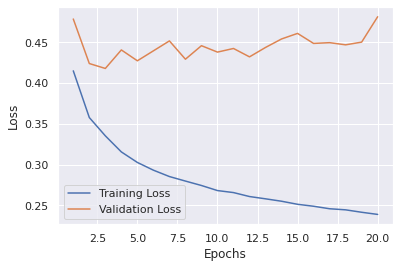

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

The validation MAE stays in the low 0.40s: we cannot even beat our common-sense baseline using the small convnet. Again, this is because 
our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. 
towards the beginning, towards the end, etc.). Since more recent datapoints should be interpreted differently from older datapoints in the 
case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an 
issue on IMDB, because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently 
of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing 
step before a RNN. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed 
with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences 
of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.


This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. It is very 
effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to 
manipulate much longer sequences, we could either look at data from further back (by increasing the `lookback` parameter of the data 
generator), or look at high-resolution timeseries (by decreasing the `step` parameter of the generator). Here, we will chose (somewhat 
arbitrarily) to use a `step` twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one 
point per 30 minutes.

In [0]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two `Conv1D` layers and following-up with a `GRU` layer:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])),
  tf.keras.layers.MaxPooling1D(3),
  tf.keras.layers.Conv1D(32, 5, activation='relu'),
  tf.keras.layers.GRU(32, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer = tf.keras.optimizers.RMSprop(),
              loss = 'mae')

history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 82s 164ms/step - loss: 0.3314 - val_loss: 0.3161
Epoch 2/20
50

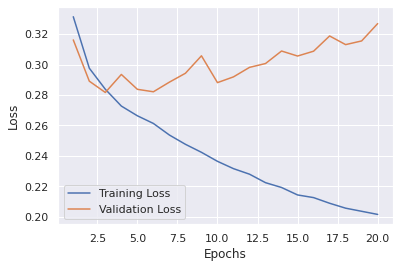

In [0]:
import seaborn as sns
sns.set()

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is 
looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.

## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing 
temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of `Conv1D` 
layers and `MaxPooling1D` layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D 
convnet as a preprocessing step before a RNN, shortening the sequence and extracting useful representations for the RNN to process.
